In [1]:
from dragonn.tutorial_utils import *
from dragonn.models import SequenceDNN

In [2]:
model = SequenceDNN.load('../../processed_data/peak_tile/hyperparam_tuned_best_retrain.arch.json',
                '../../processed_data/peak_tile/hyperparam_tuned_best_retrain.weights.h5')

Using Theano backend.
/Users/Kimberly/anaconda2/envs/dragonn_kernel/lib/python2.7/site-packages/Keras-0.3.3-py2.7.egg/keras/backend/theano_backend.py:788: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/Users/Kimberly/anaconda2/envs/dragonn_kernel/lib/python2.7/site-packages/Keras-0.3.3-py2.7.egg/keras/backend/theano_backend.py:788: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/Users/Kimberly/anaconda2/envs/dragonn_kernel/lib/python2.7/site-packages/Keras-0.3.3-py2.7.egg/keras/backend/theano_backend.py:788: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')
/Users/Kimberly/anaconda2/envs/dragonn_kernel/lib/python2.7/site-packages/theano/tensor/basic.py:2184: UserWarning: theano.tensor.round() chang

In [3]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import pandas as pd
from random import choice

Let's visualize the first convolutional layer. There are 85, so we'll look at them in chunks.

In [4]:
filters = model.get_sequence_filters()
filters.shape

(85, 4, 14)

In [5]:
def plot_filters(conv_filters, filter_num):
    fig = plt.figure(figsize=(15,8))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    num_plots_per_axis = int(len(conv_filters)**0.5) + 1
    for i, conv_filter in enumerate(conv_filters):
        ax = fig.add_subplot(num_plots_per_axis, num_plots_per_axis, i+1)
        add_letters_to_axis(ax, conv_filter.T)
        ax.axis("off")
        ax.set_title("Filter %s" % (str(filter_num+i+1)))

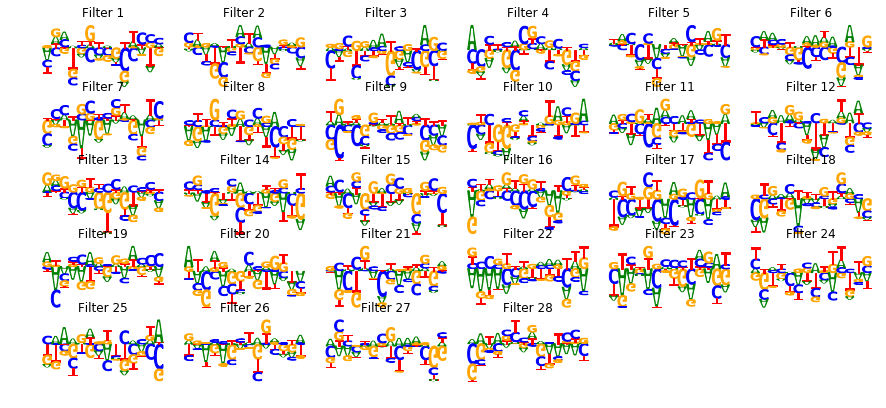

In [6]:
plot_filters(filters[:28], 0)

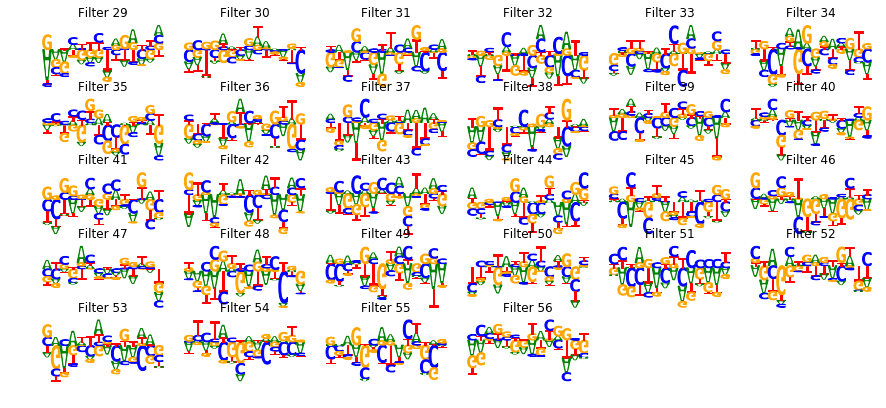

In [7]:
plot_filters(filters[28:56], 28)

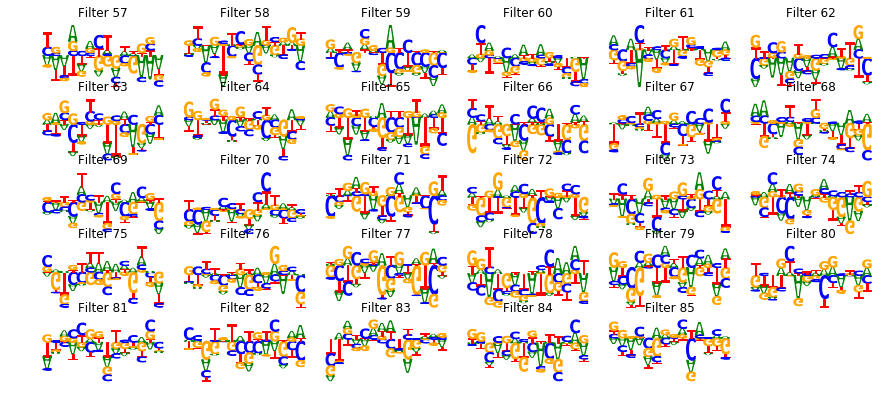

In [8]:
plot_filters(filters[56:], 56)

Let's see if we can turn the first convolutional filter weights into an actual position probability matrix so we can search against a database of motifs.

In [9]:
weights = filters[1]
weights.shape

(4, 14)

4 rows, one for each nucleotide, and 14 columns across, one for each position.

In [10]:
weights

array([[ -6.27984479e-02,   1.97234988e-01,  -2.37060592e-01,
          6.04025498e-02,  -4.92841482e-01,   1.40578430e-02,
          3.54661524e-01,   1.30168021e-01,   3.71098191e-01,
         -5.26141822e-01,  -2.19678313e-01,  -3.14054452e-02,
          6.61653727e-02,  -2.55987674e-01],
       [  3.06392074e-01,  -2.39731804e-01,  -1.11715861e-01,
          4.97441515e-02,  -4.68113601e-01,  -9.34713259e-02,
          2.23081484e-01,  -1.96354344e-01,   2.98888803e-01,
          6.00158572e-02,  -1.56967685e-01,  -8.60915855e-02,
         -1.92337081e-01,  -3.47026825e-01],
       [  1.43992305e-01,   3.37790363e-02,   1.12079173e-01,
         -4.64766562e-01,  -2.92210400e-01,  -1.56724498e-01,
          1.06796242e-01,  -1.85285266e-02,  -4.38853621e-01,
         -1.39809385e-01,  -1.59769759e-01,   1.53588042e-01,
          5.89036606e-02,   2.94439048e-01],
       [ -6.50824755e-02,   2.30656058e-01,  -2.22323030e-01,
         -5.30600846e-01,   2.58609653e-02,   2.30300486e-0

Let's load in PWMs for E. coli TFs that were generated in R from SwissRegulon PFMs for 97 TFs.

In [11]:
# both files must be the same number of lines
infile = open('../../processed_data/peak_tile/just_pwms.txt')
names = open('../../processed_data/peak_tile/names_pwms.txt')

pwms = {}
for line in infile:
    values = map(float, line.strip().split(','))
    matrix = np.matrix(values)
    matrix = matrix.reshape(4, len(values)/4)
    name = names.readline()
    pwms[name.strip()] = matrix

In [12]:
pwms[pwms.keys()[0]]

matrix([[-0.8096412,  1.7057425, -4.       , -4.       , -4.       ,
         -4.       , -4.       ,  1.9533315, -1.6596685],
        [ 1.8106819, -4.       , -4.       ,  1.0666712,  0.8361587,
         -4.       , -4.       , -0.8096412, -1.6961298],
        [-0.8501533,  1.3799639, -4.       ,  1.908503 , -4.       ,
         -4.       , -1.6596685,  1.8106819, -4.       ],
        [-4.       , -1.6596685,  1.0224766, -4.       ,  0.6659122,
         -4.       ,  1.1874612, -0.8501533,  0.1090896]])

For each filter, let's grab the "maximum" sequence, or the sequence that gives the highest weights for each filter.

In [13]:
def filter_get_max_seq(conv_filter):
    # order of columns is ACGT
    nts = ['A', 'C', 'G', 'T']
    # grab max value in each column
    max_nts = [nts[np.argmax(conv_filter[:, i])] for i in range(conv_filter.shape[1])]
    max_seq = ''.join(max_nts)
    return max_seq

In [14]:
max_filter_seqs = [filter_get_max_seq(conv_filter) for conv_filter in filters]

In [15]:
max_filter_seqs[0:10]

['GGAATGTACTTCCC',
 'CTGATTATACCGAG',
 'GGCGGAATCGTAGC',
 'ATCTCACGCGCTAC',
 'TACTCGGATCTAGT',
 'CAACTAAATATACG',
 'TCCTGCTCCTACTC',
 'CTTGTCGCCGAACG',
 'TGTGTGTTATATTT',
 'GTCACACAATACGA']

Now let's scan these sequences against the PWMs. If PWM and filter sequence is uneven, we'll start the scan at each possible position and take the maximum score.

In [16]:
pwm_lengths = [pwms[x].shape[1] for x in pwms]
from collections import Counter
Counter(pwm_lengths)

Counter({6: 1,
         8: 1,
         9: 5,
         10: 3,
         11: 1,
         13: 2,
         14: 4,
         16: 1,
         17: 11,
         18: 7,
         19: 14,
         20: 6,
         21: 3,
         22: 1,
         23: 1,
         24: 3,
         25: 11,
         26: 11,
         27: 2,
         28: 8,
         30: 1})

In [87]:
def pwm_scan_sequence(seq, pwm):
    # get index of each nt in sequence so we can reference matrix
    nts = ['A', 'C', 'G', 'T']
    nt_index = [nts.index(nt) for nt in seq]
    scores = []
    pwm_length = pwm.shape[1]
    if pwm_length <=  len(seq):
        for i in range(len(seq) - pwm_length + 1):
            nt_index = [nts.index(nt) for nt in seq[i:i+pwm_length]]
            # based on index, grab corresponding weight from PWM
            pwm_weights = [pwm[nt_index[j], j] for j in range(pwm_length)]
            score = sum(pwm_weights)
            scores.append(score)
    else: # PWM longer than seq
        for i in range(pwm_length - len(seq)):
            nt_index = [nts.index(nt) for nt in seq]
            pwm_weights = [pwm[nt_index[j], i+j] for j in range(len(nt_index))]
            score = sum(pwm_weights)
            scores.append(score)
            
    max_score = max(scores)
    return max_score

In [58]:
filter_info = pd.DataFrame(max_filter_seqs, columns = ['seq'])

max_scores = []
best_pwms = []
for i in range(len(filter_info)):
    seq = filter_info.seq[i]
    pwm_scores = [pwm_scan_sequence(seq, pwms[x]) for x in pwms]
    max_score = max(pwm_scores)
    best_pwm = pwms.keys()[pwm_scores.index(max_score)]
    max_scores.append(max_score)
    best_pwms.append(best_pwm)

filter_info['max_pwm_score'] = max_scores
filter_info['best_pwm'] = best_pwms

In [59]:
filter_info.head()

,seq,max_pwm_score,best_pwm
0,GGAATGTACTTCCC,2.499245,CRP_25-152
1,CTGATTATACCGAG,2.911742,Fis_26-83
2,GGCGGAATCGTAGC,4.702354,IDrL_9-36
3,ATCTCACGCGCTAC,5.213054,RhaS_18-2
4,TACTCGGATCTAGT,6.112225,CueR_22-0


In [118]:
Counter(filter_info.best_pwm)

Counter({'Ada_28-0': 1,
         'ArcA_28-37': 1,
         'CRP_25-12': 2,
         'CRP_25-152': 3,
         'CRP_25-18': 1,
         'CRP_25-22': 2,
         'CRP_25-81': 1,
         'CRP_25-83': 1,
         'CueR_22-0': 5,
         'CytR_24-5': 1,
         'DcuR_25-2': 1,
         'DeoR_19-5': 1,
         'FNR_17-9': 1,
         'FhlA_30-0': 3,
         'Fis_26-104': 1,
         'Fis_26-108': 1,
         'Fis_26-109': 2,
         'Fis_26-25': 3,
         'Fis_26-32': 3,
         'Fis_26-37': 4,
         'Fis_26-4': 4,
         'Fis_26-48': 2,
         'Fis_26-83': 4,
         'Fur_21-21': 1,
         'GadE_19-3': 1,
         'GcvA_25-1': 1,
         'H_NS_28-14': 3,
         'H_NS_28-19': 1,
         'H_NS_28-24': 2,
         'IDgC_25-2': 2,
         'IDnR_6-5': 1,
         'IDrL_9-1': 3,
         'IDrL_9-3': 2,
         'IDrL_9-36': 3,
         'IHF_19-3': 1,
         'IHF_19-54': 2,
         'Lrp_17-26': 1,
         'Mlc_26-2': 1,
         'NorR_11-0': 1,
         'OmpR_17-11': 1,

In [61]:
len(Counter(filter_info.best_pwm))

46

Well, at least everything wasn't randomly hit, only about half the PWMs show up as a best match. Let's calculate the best possible score for each PWM and an empirical p-value given 1000 random sequences the length of the PWM.

In [125]:
tf_counts = Counter([x.split('_')[0] for x in filter_info.best_pwm]).most_common()
tf_counts

[('Fis', 24),
 ('CRP', 10),
 ('IDrL', 8),
 ('H', 6),
 ('CueR', 5),
 ('FhlA', 3),
 ('PhoP', 3),
 ('PhoB', 3),
 ('IHF', 3),
 ('TyrR', 2),
 ('IDgC', 2),
 ('IDnR', 1),
 ('ArcA', 1),
 ('Ada', 1),
 ('FNR', 1),
 ('NorR', 1),
 ('RhaS', 1),
 ('DeoR', 1),
 ('Lrp', 1),
 ('CytR', 1),
 ('Mlc', 1),
 ('Fur', 1),
 ('OmpR', 1),
 ('TrpR', 1),
 ('GadE', 1),
 ('GcvA', 1),
 ('DcuR', 1)]

In [131]:
tuple([x[1] for x in tf_counts])

(24,
 10,
 8,
 6,
 5,
 3,
 3,
 3,
 3,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1)

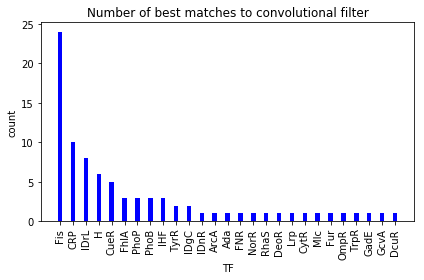

In [140]:
fig, ax = plt.subplots()

index = range(len(tf_counts))
bar_width = 0.35

rects = ax.bar(index, tuple([x[1] for x in tf_counts]), bar_width, color='b')

ax.set_xlabel('TF')
ax.set_ylabel('count')
ax.set_title('Number of best matches to convolutional filter')
ax.set_xticks(index)
ax.set_xticklabels(tuple([x[0] for x in tf_counts]), rotation='vertical')

fig.tight_layout()
plt.show()

In [84]:
# calculate max score for each pwm
max_pwm_scores = {x : np.sum(pwms[x].max(axis = 0)) for x in pwms}

In [106]:
def empirical_pval(pwm, trials, score):
    nts = ['A', 'C', 'G', 'T']
    seq_length = pwm.shape[1]
    random_seqs = [''.join([choice(nts) for i in range(seq_length)]) for j in range(trials)]
    scores = [pwm_scan_sequence(seq, pwm) for seq in random_seqs]
    score_mean = np.mean(scores)
    # what is the probability of getting a score as far away from bootstrapped mean
    score_diff = abs(score - score_mean)
    empirical_pval = (len(filter(lambda x: x < score_mean - score_diff, scores)) + 
    len(filter(lambda x : x > score_mean + score_diff, scores))) / float(trials)
    return empirical_pval

In [108]:
pvals = []
for i in range(len(filter_info)):
    score = filter_info.max_pwm_score[i]
    pwm = pwms[filter_info.best_pwm[i]]
    pvals.append(empirical_pval(pwm, 1000, score))

filter_info['empirical_pval'] = pvals

In [109]:
filter_info.head()

,seq,max_pwm_score,best_pwm,empirical_pval
0,GGAATGTACTTCCC,2.499245,CRP_25-152,0.003
1,CTGATTATACCGAG,2.911742,Fis_26-83,0.000
2,GGCGGAATCGTAGC,4.702354,IDrL_9-36,0.010
3,ATCTCACGCGCTAC,5.213054,RhaS_18-2,0.000
4,TACTCGGATCTAGT,6.112225,CueR_22-0,0.000


In [110]:
Counter(filter_info.empirical_pval)

Counter({0.0: 50,
         0.001: 14,
         0.002: 7,
         0.003: 7,
         0.004: 1,
         0.006: 2,
         0.009: 2,
         0.01: 1,
         0.011: 1})